In [1]:
import pandas as pd
import numpy as np
import torch as pt
import tqdm
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

#from ml_lib.clusters.root_cluster import RootCluster as Root
from ml_lib.clusters.data_cluster import DataCluster as Data
from ml_lib.clusters.dense_cluster import DenseCluster as Dense
from ml_lib.clusters.recurse_cluster import RecurseCluster as Recurse
from ml_lib.clusters.merge_cluster import MergeCluster as Merge
from ml_lib.controllers.controller import Controller as Control

from ml_lib.utils import learners, inits, activators, recursors, splitters, losses

pt.set_default_tensor_type('torch.FloatTensor')
#pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
dataset = pd.read_csv('data_files/market_data.csv', index_col = 'record_date')
dataset = pd.DataFrame(index = pd.date_range(dataset.index.min(), dataset.index.max())).join(
    dataset, how = 'left'
).fillna(method = 'ffill').fillna(method = 'bfill')

offset_suffix = 'next'
dataset = dataset.join(dataset.shift(), how = 'left', rsuffix = '_%s' % offset_suffix).dropna()

In [3]:
feature_cols = ['avg_price']
target_cols = ['%s_%s' % (col, offset_suffix) for col in feature_cols]

In [4]:
init = inits.Orthogonal
init_params = {
    'xavier': True
}

learner = learners.ADAM
learner_params = {
    'learn_rate': 1e-1,
    'scale_features': True
}

control = Control()
control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter = splitters.Validation, splitter_params = {},
        loss = losses.AbsErr, loss_params = {'percent': True}
    )
)
control.add_link(
    Recurse(
        'recurse_cluster',
        recursor = recursors.SingleSmooth, recursor_params = {
            'return_types': ['level'],
            'return_horizons': [1]
        },
        learner = learner, learner_params = learner_params
    ),
    'data_cluster', 'input', data_cols = feature_cols
)
control.link_clusters('recurse_cluster', 'data_cluster', data_cols = target_cols)

In [5]:
control.init_clusters()
control.train_model(500)
control.deinit_clusters()

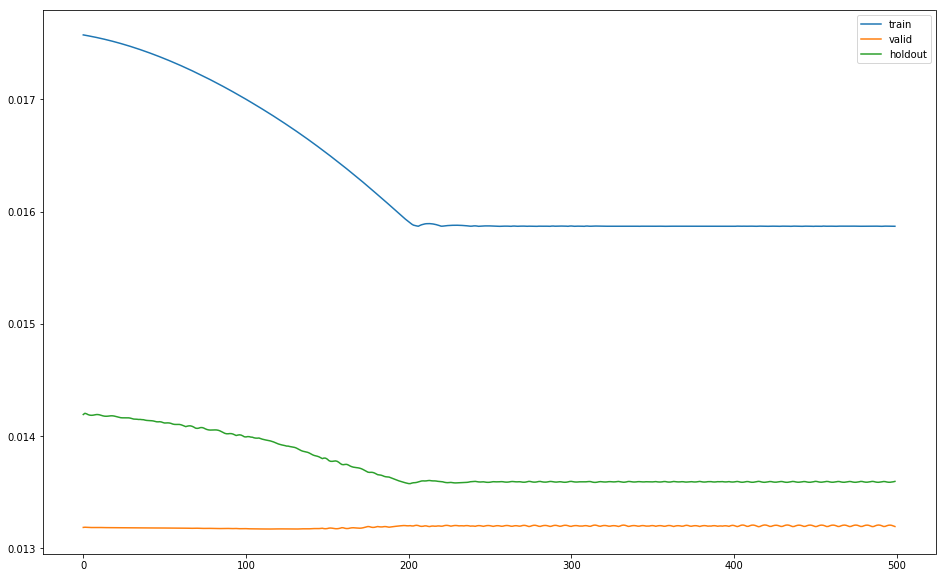

In [6]:
control.plot_losses()

In [7]:
control.clusters['recurse_cluster'].coefs

[('level_balance', tensor([0.2531], requires_grad=True)),
 ('level_seed', tensor([6.1233], requires_grad=True))]